In [1]:
# Leitura do CSV
import pandas as pd
import numpy as np
import spotipy
import csv
import sys
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import oauth2

In [2]:
artists = pd.read_csv('artists.csv')
data_by_artist = pd.read_csv('data_by_artist_o.csv')
data_by_genres = pd.read_csv('data_by_genres_o.csv')
data_by_year = pd.read_csv('data_by_year_o.csv')
data = pd.read_csv('data_o.csv')
tracks = pd.read_csv('tracks.csv')

In [3]:
# Getting artist that have genres
artists_with_genres = artists.copy()
artists_with_genres["has_genre"] = artists_with_genres["genres"] != "[]"
artists_with_genres.drop(artists_with_genres[artists_with_genres['has_genre'] == False].index, inplace=True)
# Getting artist that have less than 10 genres
artists_with_genres["genres_list"] = artists_with_genres["genres"].apply(eval)
artists_with_genres["multiple_genres"] = [True if (len(x) > 10) else False for x in artists_with_genres["genres_list"]]
artists_with_genres.drop(artists_with_genres[artists_with_genres['multiple_genres'] == True].index, inplace=True)
artists_with_genres["genres"] = artists_with_genres["genres"].str.replace("'", "")
artists_with_genres["genres"] = artists_with_genres["genres"].str.replace("[", "", regex = True)
artists_with_genres["genres"] = artists_with_genres["genres"].str.replace("]", "", regex = True)
artists_with_genres.head()

,id,followers,genres,name,popularity,has_genre,genres_list,multiple_genres
45,0VLMVnVbJyJ4oyZs2L3Yl2,71.0,carnaval cadiz,Las Viudas De Los Bisabuelos,6,True,[carnaval cadiz],False
46,0dt23bs4w8zx154C5xdVyl,63.0,carnaval cadiz,Los De Capuchinos,5,True,[carnaval cadiz],False
47,0pGhoB99qpEJEsBQxgaskQ,64.0,carnaval cadiz,Los “Pofesionales”,7,True,[carnaval cadiz],False
48,3HDrX2OtSuXLW5dLR85uN3,53.0,carnaval cadiz,Los Que No Paran De Rajar,6,True,[carnaval cadiz],False
136,22mLrN5fkppmuUPsHx6i2G,59.0,"classical harp, harp",Vera Dulova,3,True,"[classical harp, harp]",False


In [4]:
genres_dict = {}
for index, artist in artists_with_genres.iterrows():
  for genre in artist['genres_list']:
    if genre in genres_dict:
      genres_dict[genre]+=1
    else:
      genres_dict[genre]=1
genres_dict = sorted(genres_dict.items(), key= lambda x:x[1], reverse=True)
#print(genres_dict)

[('pop', 558), ('dance pop', 554), ('electro house', 544), ('classical performance', 502), ('latin', 498), ('hip hop', 470), ('rock', 462), ('pop rap', 454), ('french hip hop', 452), ('rap', 447), ('latin rock', 446), ('edm', 444), ('calming instrumental', 440), ('electropop', 428), ('lo-fi beats', 423), ('indie rock', 419), ('pop edm', 419), ('post-teen pop', 415), ('modern rock', 408), ('german hip hop', 406), ('modern alternative rock', 406), ('k-pop', 406), ('tropical', 405), ('pop rock', 401), ('underground hip hop', 400), ('indie folk', 396), ('indie poptimism', 391), ('europop', 385), ('filmi', 381), ('urban contemporary', 377), ('funk', 376), ('pop dance', 369), ('background music', 368), ('indian classical', 367), ('country rock', 365), ('alternative r&b', 365), ('tropical house', 364), ('stomp and holler', 363), ('corrido', 363), ('trap', 361), ('rock en espanol', 360), ('german pop', 358), ('otacore', 358), ('german rock', 357), ('escape room', 357), ('regional mexican', 353

In [5]:
main_genres = {
  'classical':'orchestra[\s\S]*|\b?[\s\S]*classical[\s\S]*\b?|[\s\S]*piano[\s\S]+|opera',
  'rock':r'[\s\S]+rock[\s\S]*|[\s\S]+metal[\s\S]*|[\s\S]+punk[\s\S]*',
  'pop':r'[\s\S]+pop[\s\S]*',
  'rap':r'[\s\S]* rap[\s\S]*',
  'jazz':r'[\s\S]*jazz[\s\S]*|bossa nova',
  'reggae':r'\b[\s\S]*reggae|latin[\s\S]*',
  'folk':r"[\s\S]*folk[\s\S]*|\brebetiko|hawaiian, jawaiian|ukulele|duranguense|grupera|ranchera|[\s\S]*regional mexican|norteno",
  'country':r'[\s\S]*country[\s\S]*|\btejano\b',
  'rnb':r'[\s\S]*blues[\s\S]*|[\s\S]*r&b[\s\S]*',
  'funk':r'[\s\S]*funk[\s\S]*|[\s\S]*disco[\s\S]*|[\s\S]*hip hop[\s\S]*',
  'edm':r'electronica|[\s\S]*edm[\s\S]*|electro house|electronic trap'
}

for genre in main_genres:
  if genre == 'classical':
    artists_with_genres["genres_main"]=artists_with_genres["genres"].str.replace(main_genres[genre],genre, regex = True)
  else:
    artists_with_genres["genres_main"]=artists_with_genres["genres_main"].str.replace(main_genres[genre],genre, regex = True)

pd.set_option("display.max_rows",None)
artists_with_genres["genres_main"].value_counts().head(11)

rock         47732
pop          36476
funk         14370
classical     9901
folk          9429
jazz          9078
rap           6907
rnb           3679
reggae        2602
country       1846
edm           1474
Name: genres_main, dtype: int64

In [6]:
# Creating a dictionary which categorises an artist's work into a main genre of music

artist_dictionary={}
for index, row in artists_with_genres.iterrows():
    artist_id=row["id"]
    artist_genre=row["genres_main"]
    artist_dictionary[artist_id]=artist_genre

In [7]:
tracks_with_genres = tracks.copy()
tracks_with_genres.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [8]:
#Adding a genre column in data2 by using information in dictionary created above
tracks_with_genres["id_artists"] = tracks_with_genres["id_artists"].str.replace("\[","", regex = True)
tracks_with_genres["id_artists"] = tracks_with_genres["id_artists"].str.replace("\]","", regex = True)
tracks_with_genres["id_artists"] = tracks_with_genres["id_artists"].str.replace(", ",",")
tracks_with_genres["id_artists"] = tracks_with_genres["id_artists"].str.split(",")

def genre_according_artist(column):
    music_style=[]
    for artist in column:
        artist=artist.strip("'")
        if artist in artist_dictionary:
            #print(artist)
            music_style.append(artist_dictionary[artist])
    return music_style
            
tracks_with_genres["genre"] = tracks_with_genres["id_artists"].apply(genre_according_artist)
tracks_with_genres.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,...,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,[]
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,...,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,[]
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,...,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,"[tango, vintage tango]"
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,...,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,"[tango, vintage tango]"
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,...,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,"[adult standards, big band, easy listening, lo..."


In [9]:
tracks_with_genres["has_genre"] = [x != [] for x in tracks_with_genres["genre"]]
tracks_with_genres.drop(tracks_with_genres[tracks_with_genres['has_genre'] == False].index, inplace=True)

tracks_with_genres["genres_list"] = [len(x) > 1 for x in tracks_with_genres["genre"]]
tracks_with_genres.drop(tracks_with_genres[tracks_with_genres['genres_list'] == True].index, inplace=True)

In [10]:
tracks_with_genres['genre_string'] = [','.join(map(str, l)) for l in tracks_with_genres['genre']]

tracks_with_genres["genre_string"].value_counts().head(11)

rock         145759
pop          132463
jazz          23793
folk          13403
funk          10578
classical      9500
hoerspiel      8424
rap            5732
reggae         3764
country        2987
rnb            2759
Name: genre_string, dtype: int64

In [11]:
training_tracks = tracks_with_genres.query("genre_string in ['classical','rock','pop','rap','jazz','reggae','folk','country','rnb','funk','edm']")
training_tracks.to_csv('training_dataset.csv')
training_tracks.head(11)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre,has_genre,genres_list,genre_string
149,2wAfHM7Whz67VFbdanhZlk,Nobody Knows You When You're Down and Out,41,177133,0,['Bessie Smith'],['5ESobCkc6JI4tIMxQttqeg'],1923,0.614,0.0423,...,0.996,0.002930,0.1830,0.211,89.822,4,[jazz],True,False,jazz
151,2AZgaYZSwUosJD71J2N2Zo,'Tain't Nobody's Bizness If I Do,30,206600,0,['Bessie Smith'],['5ESobCkc6JI4tIMxQttqeg'],1923,0.537,0.0443,...,0.996,0.000265,0.1520,0.137,80.468,4,[jazz],True,False,jazz
152,7lRFR5GJCxK87ZbVMtQSeS,Ain't Misbehavin',28,192600,0,['Louis Armstrong'],['19eLuQmk9aCobbVDHc6eek'],1923,0.665,0.2540,...,0.976,0.002170,0.6440,0.503,125.734,4,[jazz],True,False,jazz
153,6XTvSCqGLLH0vzQQRn55hz,"Empty Bed Blues, Pt. 1",27,181173,0,['Bessie Smith'],['5ESobCkc6JI4tIMxQttqeg'],1923,0.709,0.0620,...,0.995,0.003410,0.1200,0.553,85.854,4,[jazz],True,False,jazz
154,6qRvnXftofjYJm1Mg98UWL,Need a Little Sugar in My Bowl,27,167640,0,['Bessie Smith'],['5ESobCkc6JI4tIMxQttqeg'],1923,0.693,0.0270,...,0.992,0.000000,0.1340,0.402,75.749,4,[jazz],True,False,jazz
155,0V1iYWPXCBTaB6dhbiprGF,Send Me to the 'Lectric Chair,26,201480,0,['Bessie Smith'],['5ESobCkc6JI4tIMxQttqeg'],1923,0.771,0.0905,...,0.986,0.000141,0.1520,0.601,87.571,4,[jazz],True,False,jazz
156,6sOKopKyVWwEJKh8zztYp5,Young Woman's Blues,25,187960,0,['Bessie Smith'],['5ESobCkc6JI4tIMxQttqeg'],1923,0.525,0.2320,...,0.995,0.018100,0.4610,0.411,76.140,4,[jazz],True,False,jazz
157,0rUf1j43orpfi6f4LbVo8D,Careless Love,25,205053,0,['Bessie Smith'],['5ESobCkc6JI4tIMxQttqeg'],1923,0.587,0.1750,...,0.992,0.000318,0.0730,0.483,98.523,4,[jazz],True,False,jazz
158,1yjck0Owf0HfhY5kWHiXIQ,Me and My Gin,23,169960,0,['Bessie Smith'],['5ESobCkc6JI4tIMxQttqeg'],1923,0.710,0.0735,...,0.990,0.000000,0.0941,0.494,90.917,4,[jazz],True,False,jazz
159,2ivh0kwd7QIViw6YqDPdBA,Blue Yodel No. 9,23,157373,0,['Jimmie Rodgers'],['0Y0ZlznP6vzTS1qAm5dvTN'],1923,0.760,0.2510,...,0.969,0.000002,0.0561,0.735,108.456,4,[folk],True,False,folk


In [12]:
training_tracks.dtypes

id                   object
name                 object
popularity            int64
duration_ms           int64
explicit              int64
artists              object
id_artists           object
release_date         object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
genre                object
has_genre              bool
genres_list            bool
genre_string         object
dtype: object

In [13]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow.keras import callbacks
from tensorflow import keras
from tensorflow.keras import layers

In [14]:
X = training_tracks.copy().dropna()

In [15]:
y = X.pop('popularity')

In [16]:
artists = X['artists']
artists.head()

149       ['Bessie Smith']
151       ['Bessie Smith']
152    ['Louis Armstrong']
153       ['Bessie Smith']
154       ['Bessie Smith']
Name: artists, dtype: object

In [17]:
features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']

In [18]:
preprocessor = make_column_transformer(
    (StandardScaler(), features_num)
)

In [32]:
X = X[['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']]

danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
dtype: object

In [20]:
def group_split(X, y, group, train_size=0.80):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [11]


In [21]:
early_stopping = callbacks.EarlyStopping(min_delta=0.001,
                                        patience= 5,
                                        restore_best_weights=True)

Epoch 1/100
4412/4412 [==============================] - 13s 2ms/step - loss: 0.1535 - val_loss: 0.1250
Epoch 2/100
4412/4412 [==============================] - 9s 2ms/step - loss: 0.1259 - val_loss: 0.1243
Epoch 3/100
4412/4412 [==============================] - 9s 2ms/step - loss: 0.1247 - val_loss: 0.1245
Epoch 4/100
4412/4412 [==============================] - 9s 2ms/step - loss: 0.1239 - val_loss: 0.1232
Epoch 5/100
4412/4412 [==============================] - 9s 2ms/step - loss: 0.1235 - val_loss: 0.1238
Epoch 6/100
4412/4412 [==============================] - 9s 2ms/step - loss: 0.1233 - val_loss: 0.1236
Epoch 7/100
4412/4412 [==============================] - 9s 2ms/step - loss: 0.1231 - val_loss: 0.1229
Epoch 8/100
4412/4412 [==============================] - 9s 2ms/step - loss: 0.1230 - val_loss: 0.1227
Epoch 9/100
4412/4412 [==============================] - 9s 2ms/step - loss: 0.1230 - val_loss: 0.1232
Minimum Validation Loss: 0.1227


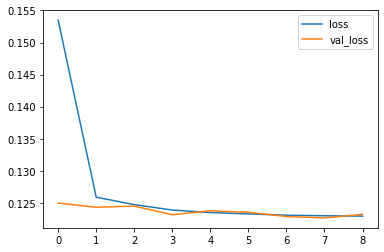

In [22]:
model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [23]:
client_id = 'ddf5739029b0474587bc3f845f7220a0'
client_secret = '83758fd8a9974ea0ae9e3689e9803c8e'

In [24]:
username ='12166356598'
scope = 'playlist-read-private'
redirect_uri = 'http://localhost:9001/callback'
playlist = '2ISRFOh87p6vEnCfj2EKpa'


token = util.prompt_for_user_token(username,
                                   scope,
                                   client_id,   
                                   client_secret,     
                                   redirect_uri)

In [25]:
def analyze_playlist(creator, playlist_id):
    
    # Create empty dataframe
    playlist_features_list = ["artist","album","track_name",  "track_id","danceability","energy","key","loudness","mode", "speechiness","instrumentalness","liveness","valence","tempo", "duration_ms","time_signature"]
    
    playlist_df = pd.DataFrame(columns = playlist_features_list)
    
    # Loop through every track in the playlist, extract features and append the features to the playlist df
    
    playlist = sp.user_playlist_tracks(creator, playlist_id)["items"]
    for track in playlist:
        # Create empty dict
        playlist_features = {}
        # Get metadata
        playlist_features["artist"] = track["track"]["album"]["artists"][0]["name"]
        playlist_features["album"] = track["track"]["album"]["name"]
        playlist_features["track_name"] = track["track"]["name"]
        playlist_features["track_id"] = track["track"]["id"]
        
        # Get audio features
        audio_features = sp.audio_features(playlist_features["track_id"])[0]
        for feature in playlist_features_list[4:]:
            playlist_features[feature] = audio_features[feature]
        
        # Concat the dfs
        track_df = pd.DataFrame(playlist_features, index = [0])
        playlist_df = pd.concat([playlist_df, track_df], ignore_index = True)
        
    return playlist_df

In [26]:
if token:
    sp = spotipy.Spotify(auth = token)  
    playlist = analyze_playlist(username,playlist)
playlist.head(10)

,artist,album,track_name,track_id,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Post Malone,Hollywood's Bleeding,Circles,21jGcNKet2qwijlDFuPiPb,0.695,0.762,0,-3.497,1,0.0395,0.002440,0.0863,0.553,120.042,215280,4
1,Vitão,Complicado,Complicado,52vPpP2gEYaBROIS77J38P,0.734,0.484,7,-7.486,0,0.1300,0.000000,0.2240,0.499,130.050,179339,4
2,Post Malone,Hollywood's Bleeding,Goodbyes (feat. Young Thug),0t3ZvGKlmYmVsDzBJAXK8C,0.548,0.653,5,-3.875,1,0.0810,0.000000,0.1030,0.163,150.068,174853,4
3,Gusttavo Lima,O Embaixador in Cariri (Ao Vivo),A Gente Fez Amor - Ao Vivo,3tv697PZNnaQN0Mn2zGhS5,0.794,0.937,8,-2.440,0,0.0336,0.000004,0.9620,0.826,134.012,237517,4
4,Luan Santana,VIVA (Ao Vivo),choque térmico - ao vivo,159ntSAEWJ9zIMOSXmQ530,0.737,0.758,2,-5.508,1,0.0402,0.000000,0.8340,0.734,126.978,180001,4
5,Marília Mendonça,Graveto (Ao Vivo),Graveto - Ao Vivo,3tc8Z4lGzOIwmIVftsxO6o,0.714,0.632,9,-5.100,1,0.0312,0.000000,0.8120,0.402,93.052,170877,4
6,Gustavo Mioto,Plaquinha de Aviso (Ao Vivo),Plaquinha de Aviso - Ao Vivo,2vdY4HzOTDkgHPlzgOVsdE,0.589,0.915,9,-2.663,0,0.2340,0.000000,0.7580,0.634,134.989,185205,4
7,Avine Vinny,Maturidade (feat. Matheus & Kauan),Maturidade (feat. Matheus & Kauan),3QkKCTSHnJlUag0GG9F1cN,0.604,0.726,7,-8.577,0,0.0494,0.000000,0.9050,0.782,148.007,194240,4
8,Alok,Vale Vale,Vale Vale,3bTjd1iQJvsfIoH8v7A0Gy,0.475,0.896,1,-5.696,0,0.0765,0.073400,0.4290,0.305,133.998,193433,4
9,Post Malone,Hollywood's Bleeding,Wow.,7xQAfvXzm3AkraOtGPWIZg,0.829,0.539,11,-7.359,0,0.2080,0.000002,0.1030,0.388,99.960,149547,4


In [27]:
playlist = playlist.drop(['time_signature'], axis = 'columns')

In [35]:
new_X = playlist[['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']]

new_X['key'] = new_X['key'].astype(float)
new_X['mode'] = new_X['mode'].astype(float)
new_X['duration_ms'] = new_X['duration_ms'].astype(float)
new_X.dtypes

C:\Users\Lucas\AppData\Local\Temp/ipykernel_12076/1844856359.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_X['key'] = new_X['key'].astype(float)
C:\Users\Lucas\AppData\Local\Temp/ipykernel_12076/1844856359.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_X['mode'] = new_X['mode'].astype(float)
C:\Users\Lucas\AppData\Local\Temp/ipykernel_12076/1844856359.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms         float64
dtype: object

In [36]:
new_y = model.predict(new_X)

3/3 [==============================] - 0s 2ms/step


In [37]:
for i in range(len(new_X)):
    print("Predicted=%s" % new_y[i])

Predicted=[-235.90002]
Predicted=[-196.24829]
Predicted=[-191.12592]
Predicted=[-260.2776]
Predicted=[-196.99655]
Predicted=[-187.20323]
Predicted=[-202.65309]
Predicted=[-212.52997]
Predicted=[-211.72824]
Predicted=[-163.65666]
Predicted=[-205.95047]
Predicted=[-186.34647]
Predicted=[-191.3522]
Predicted=[-233.04181]
Predicted=[-176.4145]
Predicted=[-199.52348]
Predicted=[-207.73784]
Predicted=[-235.78355]
Predicted=[-185.99965]
Predicted=[-137.7676]
Predicted=[-255.72316]
Predicted=[-218.71841]
Predicted=[-195.3901]
Predicted=[-207.77144]
Predicted=[-216.68756]
Predicted=[-224.30246]
Predicted=[-241.78246]
Predicted=[-220.09106]
Predicted=[-261.5741]
Predicted=[-189.5263]
Predicted=[-160.68996]
Predicted=[-122.43724]
Predicted=[-201.47624]
Predicted=[-167.32275]
Predicted=[-180.4095]
Predicted=[-366.0834]
Predicted=[-252.50938]
Predicted=[-204.84659]
Predicted=[-175.30466]
Predicted=[-193.69037]
Predicted=[-238.24763]
Predicted=[-204.75558]
Predicted=[-217.1026]
Predicted=[-171.2105]